## Individual Challenge: New Question & Datasource.
- Cristian Tedesco - fc65149

### Setup

In [3]:
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import os
import time
import seaborn as sns
import calendar
import py_stringmatching as sm
import re
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import textwrap
import random

In [4]:
PATH = 'data_sources/'
FILTERED_PATH = 'filtered/'
NTSB_DATA = 'ntsb-us-2003-2023.json'
AIRCRAFT_DATA = 'aircraft_data.csv' #'aircraft_data_cleaned.csv' # the "cleaned" one contains the data cleaning part


### Analysis

#### Load NTSB JSON Data

In [5]:
with open(PATH+NTSB_DATA, 'r', encoding='utf-8') as f:
    ntsb_raw_data = json.load(f)

# Each record is one accident/incident entry in a list
print(f'\n--- NTSB JSON loaded: {len(ntsb_raw_data)} total records found ---')

# Convert to a DataFrame (this will flatten top-level fields)
# For nested fields like 'Vehicles', we might do a separate flatten later
df_ntsb = pd.json_normalize(ntsb_raw_data, 
                            meta=[
                                'Oid','MKey','Closed','CompletionStatus','HasSafetyRec',
                                'HighestInjury','IsStudy','Mode','NtsbNumber',
                                'OriginalPublishedDate','MostRecentReportType','ProbableCause',
                                'City','Country','EventDate','State','Agency','BoardLaunch',
                                'BoardMeetingDate','DocketDate','EventType','Launch','ReportDate',
                                'ReportNum','ReportType','AirportId','AirportName','AnalysisNarrative',
                                'FactualNarrative','PrelimNarrative','FatalInjuryCount','MinorInjuryCount',
                                'SeriousInjuryCount','InvestigationClass','AccidentSiteCondition',
                                'Latitude','Longitude','DocketOriginalPublishDate'
                            ],
                            record_path=['Vehicles'],  # This flattens out the 'Vehicles' array
                            record_prefix='Vehicles.'
                           )

print('\n--- Flattened NTSB DataFrame (including Vehicles info): ---')

# print(df_ntsb.info())

# combines all injury counts to 1 column
df_ntsb['TotalInjuryCount'] = df_ntsb[['FatalInjuryCount', 'MinorInjuryCount', 'SeriousInjuryCount']].sum(axis=1)

# dropping unnecessary columns
df_ntsb.drop(columns=['AnalysisNarrative','FactualNarrative','PrelimNarrative','InvestigationClass','BoardLaunch'
                      ,'BoardMeetingDate','Launch','IsStudy','OriginalPublishedDate','DocketOriginalPublishDate'
                      ,'ReportType','ReportNum','ReportDate','MostRecentReportType','FatalInjuryCount','MinorInjuryCount'
                      ,'SeriousInjuryCount','DocketDate','Mode','HasSafetyRec','CompletionStatus','Closed'
                      ,'Vehicles.AircraftCategory','Vehicles.AmateurBuilt','Vehicles.EventID','Vehicles.AirMedical'
                      ,'Vehicles.AirMedicalType','Vehicles.flightScheduledType','Vehicles.flightServiceType'
                      ,'Vehicles.flightTerminalType','Vehicles.RegisteredOwner','Vehicles.RegulationFlightConductedUnder'
                      ,'Vehicles.RepGenFlag','Vehicles.RevenueSightseeing','Vehicles.SecondPilotPresent','Vehicles.Damage'
                      ,'AccidentSiteCondition'], inplace=True) 

# dropping NaT entries from EventDate
df_ntsb = df_ntsb.dropna(subset=['EventDate'])

# Type Conversion
df_ntsb['EventDate'] = pd.to_datetime(df_ntsb['EventDate']).dt.tz_localize(None)
df_ntsb['Vehicles.VehicleNumber'] = pd.to_numeric(df_ntsb['Vehicles.VehicleNumber'], errors='coerce').astype(int)
df_ntsb['MKey'] = pd.to_numeric(df_ntsb['MKey'], errors='coerce').astype(int)
df_ntsb['Vehicles.NumberOfEngines'] = pd.to_numeric(df_ntsb['Vehicles.NumberOfEngines'], errors='coerce').fillna(0).astype(int)
df_ntsb['Latitude'] = pd.to_numeric(df_ntsb['Latitude'], errors='coerce').astype(float)
df_ntsb['Longitude'] = pd.to_numeric(df_ntsb['Longitude'], errors='coerce').astype(float)
df_ntsb['TotalInjuryCount'] = pd.to_numeric(df_ntsb['TotalInjuryCount'], errors='coerce').astype(int)

categorical_cols = [
    'Vehicles.DamageLevel',
    'Vehicles.ExplosionType',
    'Vehicles.FireType',
    'HighestInjury',
    'EventType',
    'AccidentSiteCondition'
]

for col in categorical_cols:
    if col in df_ntsb.columns:
        df_ntsb[col] = df_ntsb[col].astype('category')

df_ntsb = df_ntsb.map(lambda x: x.lower() if isinstance(x, str) else x) # make all appropriate values lowercase

print(df_ntsb.info())

print('\n--- Saving filtered NTSB DataFrame... ---')
df_ntsb.to_pickle(PATH+'filtered/ntsb.pkl')


--- NTSB JSON loaded: 22992 total records found ---

--- Flattened NTSB DataFrame (including Vehicles info): ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23403 entries, 0 to 23402
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Vehicles.VehicleNumber        23403 non-null  int64         
 1   Vehicles.DamageLevel          23400 non-null  category      
 2   Vehicles.ExplosionType        21880 non-null  category      
 3   Vehicles.FireType             23321 non-null  category      
 4   Vehicles.SerialNumber         23283 non-null  object        
 5   Vehicles.Make                 23402 non-null  object        
 6   Vehicles.Model                23398 non-null  object        
 7   Vehicles.NumberOfEngines      23403 non-null  int64         
 8   Vehicles.RegistrationNumber   23397 non-null  object        
 9   Vehicles.FlightOperationType  21593 non-null  

#### Load Aircraft CSV Data

In [6]:
df_aircraft = pd.read_csv(PATH+AIRCRAFT_DATA, encoding='utf-8')

print(f'\n--- Aircraft CSV loaded: {df_aircraft.shape[0]} rows, {df_aircraft.shape[1]} columns ---')

# print(df_aircraft.info())

# dropping unnecessary columns
df_aircraft.drop(columns=['Unnamed: 0'], inplace=True)
df_aircraft.drop(columns=['retired'], inplace=True)

# make string values lowercase
df_aircraft['aircraft'] = df_aircraft['aircraft'].str.lower()

# Type Conversion
df_aircraft['nbBuilt'] = pd.to_numeric(df_aircraft['nbBuilt'], errors='coerce').astype(int)
df_aircraft['startDate'] = pd.to_numeric(df_aircraft['startDate'], errors='coerce').astype(int)
df_aircraft['endDate'] = pd.to_numeric(df_aircraft['endDate'], errors='coerce').astype('Int64')  # Use 'Int64' for nullable integers

print(df_aircraft.info())

print('\n--- Saving filtered Aircraft DataFrame... ---')
df_aircraft.to_pickle(PATH+'filtered/aircraft.pkl')


--- Aircraft CSV loaded: 1266 rows, 6 columns ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266 entries, 0 to 1265
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   aircraft   1266 non-null   object
 1   nbBuilt    1266 non-null   int32 
 2   startDate  1266 non-null   int32 
 3   endDate    997 non-null    Int64 
dtypes: Int64(1), int32(2), object(1)
memory usage: 31.0+ KB
None

--- Saving filtered Aircraft DataFrame... ---


#### NTSB DATA vs AIRCRAFT DATA

In [7]:
# — 1. Caricamento e preparazione dati —
df_aircraft = pd.read_csv('data_sources/aircraft_data.csv')
df_ntsb_model = df_ntsb[['NtsbNumber', 'EventDate',
                         'Vehicles.SerialNumber', 'Vehicles.RegistrationNumber',
                         'Vehicles.Make', 'Vehicles.Model']].copy()
df_ntsb_model['Vehicles.Model'] = (
    df_ntsb_model['Vehicles.Model']
    .str.lower().str.strip()
)
df_aircraft['aircraft'] = (
    df_aircraft['aircraft']
    .str.lower().str.strip()
)
df_ntsb_model.dropna(subset=['Vehicles.Model'], inplace=True)
df_aircraft.dropna(subset=['aircraft'], inplace=True)



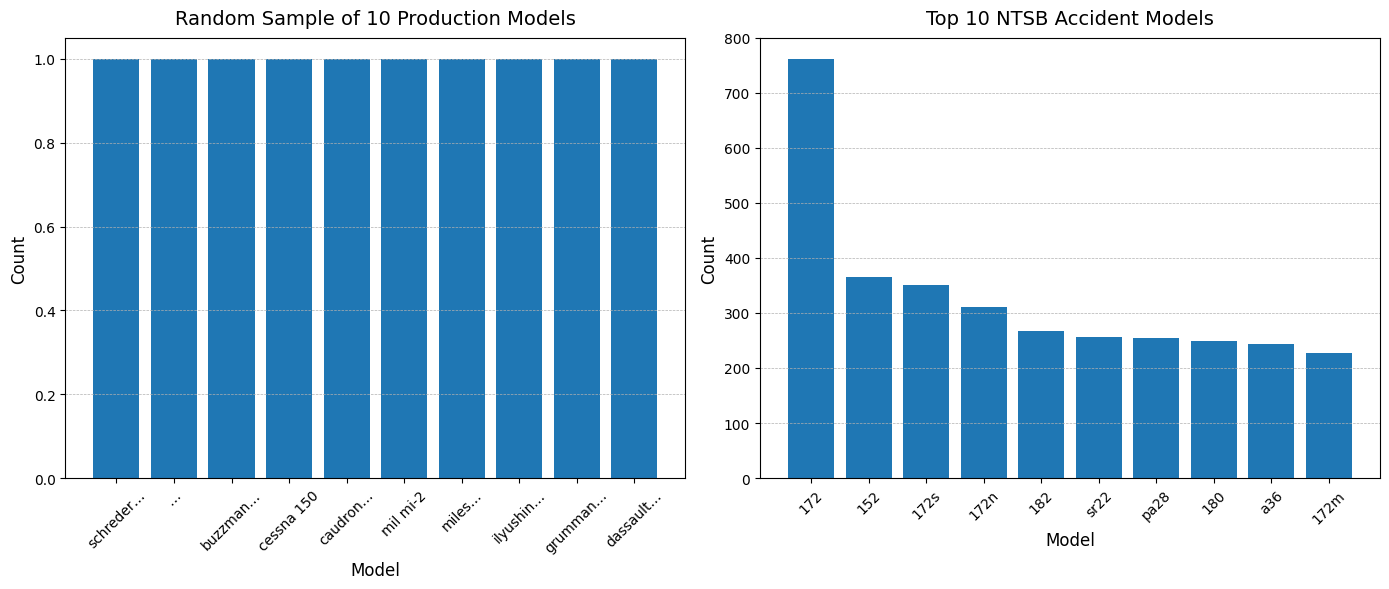

In [8]:
# === 2. Random sample of 10 models from Production Data ===
unique_air = df_aircraft['aircraft'].unique()
random.seed(42)
sample_models = random.sample(list(unique_air), 10)
sample_counts = df_aircraft['aircraft'].value_counts().reindex(sample_models).fillna(0)

# === 3. Top-10 models from NTSB Accident Data ===
top_ntsb = df_ntsb_model['Vehicles.Model'].value_counts().head(10)

# === 4. Function to shorten long labels ===
def shorten_labels(labels, max_len=12):
    return [
        lbl if len(lbl) <= max_len else textwrap.shorten(lbl, width=max_len, placeholder="…")
        for lbl in labels
    ]

air_labels = shorten_labels(sample_counts.index.tolist(), max_len=12)
nts_labels = shorten_labels(top_ntsb.index.tolist(), max_len=12)

# === 5. Plot in a single window ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: random sample bar chart
ax1.bar(air_labels, sample_counts.values)
ax1.set_title('Random Sample of 10 Production Models', fontsize=14, pad=10)
ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.tick_params(axis='x', rotation=45, labelsize=10)
ax1.yaxis.grid(True, linestyle='--', linewidth=0.5)

# Right: top-10 NTSB bar chart
ax2.bar(nts_labels, top_ntsb.values)
ax2.set_title('Top 10 NTSB Accident Models', fontsize=14, pad=10)
ax2.set_xlabel('Model', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.tick_params(axis='x', rotation=45, labelsize=10)
ax2.yaxis.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [9]:
sample_models


['schreder airmate hp-11',
 'aã©rospatiale sa 321 super frelon',
 "buzzman l'il buzzard",
 'cessna 150',
 'caudron c.714',
 'mil mi-2',
 'miles messenger',
 'ilyushin il-10',
 'grumman ov-1 mohawk',
 'dassault falcon 2000']

In [10]:
top_ntsb

Vehicles.Model
172     762
152     366
172s    351
172n    311
182     268
sr22    256
pa28    255
180     249
a36     244
172m    228
Name: count, dtype: int64

#### Profiling of ICAO DATA

In [11]:
def profile_dataframe(df, name='DataFrame'):
    print(f'\n=== Profiling {name} ===')
    print(f'Total Rows: {len(df)}')
    print(f'Total Columns: {len(df.columns)}\n')
    
    profile_results = []

    for col in df.columns:
        series = df[col]
        col_dtype = series.dtype
        
        # Basic counts
        total_count = len(series)
        missing_vals = series.isna().sum()
        non_null_count = total_count - missing_vals
        missing_perc = (missing_vals / total_count) * 100
        unique_vals = series.nunique(dropna=False)
        
        # Mode & frequency
        try:
            modes = series.mode(dropna=True)
            mode_val = modes.iloc[0] if len(modes) > 0 else np.nan
            mode_freq = (series == mode_val).sum(skipna=True)
        except:
            mode_val, mode_freq = np.nan, np.nan
        
        # Initialize placeholders
        mean_ = np.nan
        min_  = np.nan
        q25   = np.nan
        q50   = np.nan
        q75   = np.nan
        max_  = np.nan
        std_  = np.nan  # only for numeric columns

        # Numeric columns
        if pd.api.types.is_numeric_dtype(series):
            mean_ = series.mean(skipna=True)
            min_  = series.min(skipna=True)
            q25   = series.quantile(0.25)
            q50   = series.quantile(0.50)
            q75   = series.quantile(0.75)
            max_  = series.max(skipna=True)
            std_  = series.std(skipna=True)

        # Datetime columns
        elif pd.api.types.is_datetime64_any_dtype(series):
            # We can compute mean & quartiles by time. 
            # .quantile() and .mean() are valid for datetime in pandas
            # They return a Timestamp for mean, 
            # and Timestamps for quantiles
            if non_null_count > 0:
                mean_ = series.mean(skipna=True)
                min_  = series.min(skipna=True)
                q25   = series.quantile(0.25)
                q50   = series.quantile(0.50)
                q75   = series.quantile(0.75)
                max_  = series.max(skipna=True)
            # We skip std_ for datetime.

        # Categorical/object columns 
        # do not get numeric stats (we keep them as NaN).

        profile_results.append((
            col,
            str(col_dtype),
            total_count,
            non_null_count,
            missing_vals,
            round(missing_perc, 2),
            unique_vals,
            mode_val,
            mode_freq,
            mean_,
            min_,
            q25,
            q50,
            q75,
            max_,
            std_
        ))

    columns = [
        'Column', 'DataType', 'TotalCount', 'NonNullCount', 'NumMissing',
        'MissingPerc', 'Cardinality', 'Mode', 'ModeFreq',
        'Mean', 'Min', 'Q25', 'Q50', 'Q75', 'Max', 'Std'
    ]

    prof_df = pd.DataFrame(profile_results, columns=columns)
    
    return prof_df

In [15]:

df_aircraft = pd.read_csv('data_sources/combined_aircraft_data.csv')

# === 1. Data Cleaning and Normalization ===
def clean_text(s):
    """ Normalizzazione del testo: rimozione di caratteri speciali, lowercase e spazi extra. """
    return re.sub(r'\W+', ' ', str(s)).lower().strip()

# applica la normalizzazione
for col in ['model_no', 'manufacturer_code']:
    df_aircraft[col] = df_aircraft[col].apply(clean_text)

# rimuovi le righe senza model_no
df_aircraft.dropna(subset=['model_no'], inplace=True)

# === 2. Type conversion ===
# drop model_version (100% missing)
if 'model_version' in df_aircraft.columns:
    df_aircraft.drop(columns=['model_version'], inplace=True)

# cast alle categorie e numerici
df_aircraft = df_aircraft.astype({
    'manufacturer_code': 'category',
    'model_name'       : 'category',
    'model_no'         : 'category',
    'engine_count'     : 'int64',
    'engine_type'      : 'category',
    'aircraft_desc'    : 'category',
    'description'      : 'category',
    'wtc'              : 'category',
    'tdesig'           : 'category',
    'wtg'              : 'category'
})

# === 3. Profiling ===
ICAO_model_profile = profile_dataframe(df_aircraft, name='ICAO Data')
display(HTML(ICAO_model_profile.to_html()))
ICAO_model_profile.to_csv(PATH+'profiling/ICAO_model_profile.csv', index=False)



=== Profiling ICAO Data ===
Total Rows: 2270
Total Columns: 10



,Column,DataType,TotalCount,NonNullCount,NumMissing,MissingPerc,Cardinality,Mode,ModeFreq,Mean,Min,Q25,Q50,Q75,Max,Std
0,manufacturer_code,category,2270,2270,0,0.00,35,cessna,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,model_no,category,2270,2270,0,0.00,1254,nan,659,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,model_name,category,2270,1543,727,32.03,623,Huron,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,engine_count,int64,2270,2270,0,0.00,5,1,1152,1.580617,1.0,1.0,1.0,2.0,8.0,0.721375
4,engine_type,category,2270,2270,0,0.00,4,Piston,1242,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,aircraft_desc,category,2270,2270,0,0.00,4,LandPlane,2171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,description,category,2270,2270,0,0.00,18,L1P,970,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,wtc,category,2270,2270,0,0.00,5,L,1496,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,tdesig,category,2270,2270,0,0.00,526,P28A,47,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,wtg,category,2270,2267,3,0.13,9,G,1775,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### New Blocking strategy between NTSB and ICAO DATA

In [16]:
# === 1. Data Loading ===
# Caricamento dei dataset
df_aircraft = pd.read_csv('data_sources/combined_aircraft_data.csv')
df_ntsb = pd.read_pickle(PATH + FILTERED_PATH + 'ntsb.pkl')

# Selezione delle colonne necessarie
df_ntsb_model = df_ntsb[['NtsbNumber', 'EventDate', 'Vehicles.SerialNumber',
                         'Vehicles.RegistrationNumber', 'Vehicles.Make', 'Vehicles.Model']].copy()

# === 2. Data Cleaning and Normalization ===
def clean_text(s):
    """ Normalizzazione del testo: rimozione di caratteri speciali, lowercase e spazi extra. """
    return re.sub(r'\W+', ' ', str(s)).lower().strip()

# Pulizia dei dati
df_ntsb_model['Vehicles.Model'] = df_ntsb_model['Vehicles.Model'].apply(clean_text)
df_ntsb_model['Vehicles.Make'] = df_ntsb_model['Vehicles.Make'].apply(clean_text)

df_aircraft['model_no'] = df_aircraft['model_no'].apply(clean_text)
df_aircraft['manufacturer_code'] = df_aircraft['manufacturer_code'].apply(clean_text)

df_ntsb_model.dropna(subset=['Vehicles.Model'], inplace=True)
df_aircraft.dropna(subset=['model_no'], inplace=True)

# === 3. Similarity Setup ===
jw = sm.JaroWinkler()
lev = sm.Levenshtein()
jac = sm.Jaccard()  

# === 4. Precomputation degli n-gram ===
def generate_qgrams(model):
    """ Genera un insieme di trigrammi (q-grams di lunghezza 3) per una stringa data. """
    qgrams = [model[i:i+3] for i in range(len(model) - 2)]
    return set(qgrams)

# === 5. Matching with Optimized Loop ===
matches = []
matched_set = set()  # Set per controllare i duplicati di NtsbNumber + SerialNumber
serial_set = set()   # Set per controllare i duplicati di SerialNumber

for i, ntsb_row in df_ntsb_model.iterrows():
    model_ntsb = ntsb_row['Vehicles.Model']
    make_ntsb = ntsb_row['Vehicles.Make']
    grams_ntsb = generate_qgrams(model_ntsb)

    # 🔎 **Filtro preliminare basato sul Make (flessibile)**
    filtered_aircraft = df_aircraft[
        df_aircraft['manufacturer_code'].apply(lambda x: make_ntsb in x or x in make_ntsb or jw.get_sim_score(x, make_ntsb) > 0.85)
    ]
    
    # Se non ci sono candidati, passa al prossimo ciclo
    if filtered_aircraft.empty:
        continue

    # Precomputa gli n-gram per i candidati
    aircraft_grams = {index: generate_qgrams(model) for index, model in enumerate(filtered_aircraft['model_no'])}

    # 🔎 **Filtro preliminare basato sugli n-grammi**
    candidate_matches = []
    for idx, grams_aircraft in aircraft_grams.items():
        if len(grams_ntsb & grams_aircraft) >= 2:
            candidate_matches.append(filtered_aircraft.index[idx])

    if not candidate_matches:
        continue  # Nessun match possibile, passo al successivo

    # 🔎 **Controllo diretto:** se esiste un match esatto tra i candidati
    direct_match = df_aircraft.loc[candidate_matches]
    direct_match = direct_match[direct_match['model_no'] == model_ntsb]

    if not direct_match.empty:
        for _, row in direct_match.iterrows():
            match_id = f"{ntsb_row['NtsbNumber']}_{ntsb_row['Vehicles.SerialNumber']}_{row['model_no']}"
            if match_id not in matched_set and ntsb_row['Vehicles.SerialNumber'] not in serial_set:
                matches.append({
                    'NtsbNumber': ntsb_row['NtsbNumber'],
                    'EventDate': ntsb_row['EventDate'],
                    'Vehicles.SerialNumber': ntsb_row['Vehicles.SerialNumber'],
                    'Vehicles.RegistrationNumber': ntsb_row['Vehicles.RegistrationNumber'],
                    'Vehicles.Make': ntsb_row['Vehicles.Make'],
                    'Vehicles.Model': model_ntsb,
                    'Matched_Aircraft_Model': row['model_no'],
                    'engine_count': row['engine_count'],
                    'engine_type': row['engine_type'],
                    'JW_Score': 1.0,
                    'LEV_Score': 1.0,
                    'Jac_Score': 1.0,
                    'SimilarityScore': 1.0
                })
                matched_set.add(match_id)
                serial_set.add(ntsb_row['Vehicles.SerialNumber'])

        continue  # Salta il loop di matching

    # 🔎 **Controllo di Variante Generico**
    for idx in candidate_matches:
        model_aircraft = df_aircraft.loc[idx, 'model_no']

        # Numeric Filter: numbers must match if present
        nums_ntsb = re.findall(r'\d+', model_ntsb)
        nums_aircraft = re.findall(r'\d+', model_aircraft)

        if nums_ntsb and nums_aircraft and nums_ntsb != nums_aircraft:
            continue

        # Computing the Three Similarity Scores
        jw_score = jw.get_sim_score(model_ntsb, model_aircraft)
        lev_score = lev.get_sim_score(model_ntsb, model_aircraft)
        jac_score = jac.get_sim_score(list(grams_ntsb), list(generate_qgrams(model_aircraft)))

        # Linear Rule
        final_score = 0.4 * jw_score + 0.3 * lev_score + 0.3 * jac_score

        # Controllo duplicati
        match_id = f"{ntsb_row['NtsbNumber']}_{ntsb_row['Vehicles.SerialNumber']}_{model_aircraft}"
        if final_score > 0.75 and match_id not in matched_set and ntsb_row['Vehicles.SerialNumber'] not in serial_set:
            matches.append({
                'NtsbNumber': ntsb_row['NtsbNumber'],
                'EventDate': ntsb_row['EventDate'],
                'Vehicles.SerialNumber': ntsb_row['Vehicles.SerialNumber'],
                'Vehicles.RegistrationNumber': ntsb_row['Vehicles.RegistrationNumber'],
                'Vehicles.Make': ntsb_row['Vehicles.Make'],
                'Vehicles.Model': model_ntsb,
                'Matched_Aircraft_Model': model_aircraft,
                'engine_count': df_aircraft.loc[idx, 'engine_count'],
                'engine_type': df_aircraft.loc[idx, 'engine_type'],
                'JW_Score': round(jw_score, 3),
                'LEV_Score': round(lev_score, 3),
                'Jac_Score': round(jac_score, 3),
                'SimilarityScore': round(final_score, 4)
            })
            matched_set.add(match_id)
            serial_set.add(ntsb_row['Vehicles.SerialNumber'])

# === 6. Final Output ===
if not matches:
    print("No matches found with the current rules.")
else:
    df_matches = pd.DataFrame(matches)
    print(f"Matches Found: {len(df_matches)}")
    print("Columns:", df_matches.columns.tolist())
    df_matches = df_matches.sort_values(by='SimilarityScore', ascending=False)
    display(df_matches.head(25))


Matches Found: 4963
Columns: ['NtsbNumber', 'EventDate', 'Vehicles.SerialNumber', 'Vehicles.RegistrationNumber', 'Vehicles.Make', 'Vehicles.Model', 'Matched_Aircraft_Model', 'engine_count', 'engine_type', 'JW_Score', 'LEV_Score', 'Jac_Score', 'SimilarityScore']


,NtsbNumber,EventDate,Vehicles.SerialNumber,Vehicles.RegistrationNumber,Vehicles.Make,Vehicles.Model,Matched_Aircraft_Model,engine_count,engine_type,JW_Score,LEV_Score,Jac_Score,SimilarityScore
2481,era11la196,2011-03-19 14:10:00,28-24684,n7330j,piper,pa 28 140,pa 28 140,1,Piston,1.0,1.0,1.0,1.0
2574,cen10ca550,2010-09-19 20:45:00,28-26714,n333na,piper,pa 28 140,pa 28 140,1,Piston,1.0,1.0,1.0,1.0
2576,cen10ca547,2010-09-19 16:30:00,2842213,n436nd,piper,pa 28 161,pa 28 161,1,Piston,1.0,1.0,1.0,1.0
2577,era10la486,2010-09-19 12:30:00,28r-7535349,n799sq,piper,pa 28r 200,pa 28r 200,1,Piston,1.0,1.0,1.0,1.0
4380,lax04ca317,2004-09-14 08:30:00,3246185,n5300r,piper,pa 32r 301,pa 32r 301,1,Piston,1.0,1.0,1.0,1.0
2579,cen10ca582,2010-09-17 14:00:00,301-0354,n2309f,air tractor inc,at 301,at 301,1,Piston,1.0,1.0,1.0,1.0
2580,anc10la094,2010-09-15 18:40:00,18-7509044,n9699p,piper,pa 18,pa 18,1,Piston,1.0,1.0,1.0,1.0
2581,anc10la094,2010-09-15 18:40:00,18-4559,n2fd,piper,pa 18,pa 18,1,Piston,1.0,1.0,1.0,1.0
4379,ftw04la238,2004-09-14 18:15:00,31-7752154,n555mc,piper,pa 31 350,pa 31 350,2,Piston,1.0,1.0,1.0,1.0
4378,atl04ca186,2004-09-15 10:45:00,172rg1057,n948sm,cessna,172rg,172rg,1,Piston,1.0,1.0,1.0,1.0


#### Plot Engine_type

engine_type
Piston                  86.157566
Turboprop/Turboshaft     9.449929
Jet                      4.392505
Name: proportion, dtype: float64


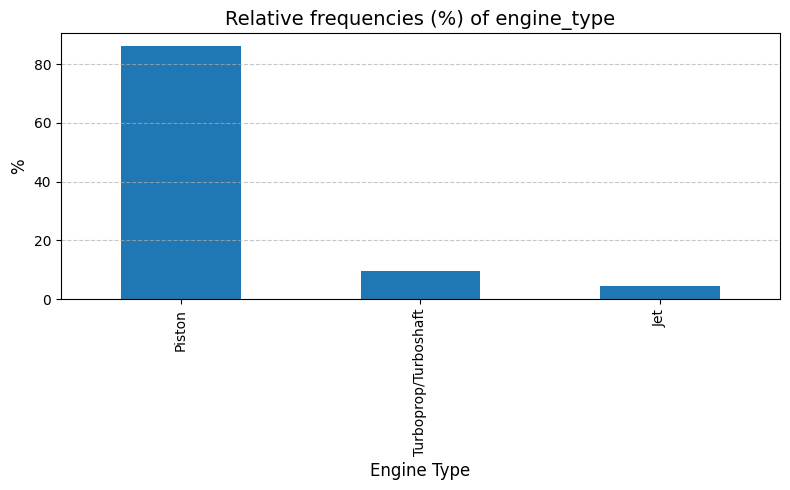

In [18]:

# 1. Calcolo delle frequenze relative
rel_freq = df_matches['engine_type'].value_counts(normalize=True)

# (opzionale) trasformale in percentuali
rel_freq_pct = rel_freq * 100
print(rel_freq_pct)

# 2. Plot a barre
fig, ax = plt.subplots(figsize=(8, 5))
rel_freq_pct.plot(kind='bar', ax=ax)

# Personalizzazione
ax.set_title('Relative frequencies (%) of engine_type', fontsize=14)
ax.set_xlabel('Engine Type', fontsize=12)
ax.set_ylabel('%', fontsize=12)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
